<a href="https://colab.research.google.com/github/Abhishek315-a/machine-larning-models/blob/main/botnet_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn

In [ ]:
!pip install -q kaggle


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vigneshvenkateswaran/bot-iot

Dataset URL: https://www.kaggle.com/datasets/vigneshvenkateswaran/bot-iot
License(s): unknown
bot-iot.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q bot-iot.zip -d bot-iot

In [ ]:
!ls bot-iot


data_10.csv  data_22.csv  data_34.csv  data_46.csv  data_58.csv  data_6.csv
data_11.csv  data_23.csv  data_35.csv  data_47.csv  data_59.csv  data_70.csv
data_12.csv  data_24.csv  data_36.csv  data_48.csv  data_5.csv	 data_71.csv
data_13.csv  data_25.csv  data_37.csv  data_49.csv  data_60.csv  data_72.csv
data_14.csv  data_26.csv  data_38.csv  data_4.csv   data_61.csv  data_73.csv
data_15.csv  data_27.csv  data_39.csv  data_50.csv  data_62.csv  data_74.csv
data_16.csv  data_28.csv  data_3.csv   data_51.csv  data_63.csv  data_7.csv
data_17.csv  data_29.csv  data_40.csv  data_52.csv  data_64.csv  data_8.csv
data_18.csv  data_2.csv   data_41.csv  data_53.csv  data_65.csv  data_9.csv
data_19.csv  data_30.csv  data_42.csv  data_54.csv  data_66.csv  data_names.csv
data_1.csv   data_31.csv  data_43.csv  data_55.csv  data_67.csv
data_20.csv  data_32.csv  data_44.csv  data_56.csv  data_68.csv
data_21.csv  data_33.csv  data_45.csv  data_57.csv  data_69.csv


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('bot-iot/data_1.csv')

/tmp/ipython-input-1795182839.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('bot-iot/data_1.csv')


In [ ]:
df.shape

(1000000, 35)

In [ ]:
df.head()

,pkSeqID,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,...,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category,subcategory
0,1,1.526344e+09,e,arp,192.168.100.1,NaN,192.168.100.3,NaN,4,240,...,2,2,120,120,0.002508,0.000836,0.000836,0,Normal,Normal
1,2,1.526344e+09,e,tcp,192.168.100.7,139,192.168.100.4,36390,10,680,...,5,5,350,330,0.006190,0.002751,0.002751,0,Normal,Normal
2,3,1.526344e+09,e,udp,192.168.100.149,51838,27.124.125.250,123,2,180,...,1,1,90,90,20.590960,0.000000,0.000000,0,Normal,Normal
3,4,1.526344e+09,e,arp,192.168.100.4,NaN,192.168.100.7,NaN,10,510,...,5,5,210,300,0.006189,0.002751,0.002751,0,Normal,Normal
4,5,1.526344e+09,e,udp,192.168.100.27,58999,192.168.100.1,53,4,630,...,2,2,174,456,0.005264,0.001755,0.001755,0,Normal,Normal


In [ ]:
names = pd.read_csv('bot-iot/data_names.csv',header=None)
names.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,pkSeqID,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,...,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category,subcategory


In [ ]:
# Safer for network traffic data
df.fillna(0, inplace=True)
print("After filling nulls with 0:", df.shape)


After filling nulls with 0: (1000000, 35)


In [ ]:
df.drop_duplicates(inplace=True)
print("After dropping duplicates:", df.shape)

After dropping duplicates: (1000000, 35)


In [ ]:
if "attack" not in df.columns:
    print("Check: Your file may have a different label column name.")

In [ ]:
columns_to_drop=["pkSeqId","saddr","daddr","sport","dport","seq","stime","ltime"]
df.drop(columns=[col for col in columns_to_drop if col in df.columns],inplace=True)
df.shape

(1000000, 28)

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [ ]:
features = df.drop("attack",axis=1)
scalar = MinMaxScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(features),columns = features.columns)
y = df["attack"]

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=8)
X_selected = selector.fit_transform(X_scaled, y)
selected_columns = X_scaled.columns[selector.get_support()]
print("Selected features:", selected_columns.tolist())

Selected features: ['pkts', 'bytes', 'dur', 'sum', 'spkts', 'dpkts', 'sbytes', 'dbytes']


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(pd.DataFrame(X_selected, columns=selected_columns), y)
print("After SMOTE:", X_resampled.shape, y_resampled.shape)

After SMOTE: (1996014, 8) (1996014,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (1596811, 8) Test size: (399203, 8)


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# ✅ Model definitions
models = {
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "MLP ANN": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# ✅ Training and Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    print(f"\n📊 {name} Performance:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))



📊 Naive Bayes Performance:
              precision    recall  f1-score   support

           0       0.97      0.18      0.31    199825
           1       0.55      0.99      0.71    199378

    accuracy                           0.59    399203
   macro avg       0.76      0.59      0.51    399203
weighted avg       0.76      0.59      0.51    399203

ROC AUC: 0.5934219148814165

📊 KNN Performance:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    199825
           1       0.96      0.99      0.98    199378

    accuracy                           0.98    399203
   macro avg       0.98      0.98      0.98    399203
weighted avg       0.98      0.98      0.98    399203

ROC AUC: 0.9970214481136171

📊 MLP ANN Performance:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79    199825
           1       0.74      0.99      0.85    199378

    accuracy                           0.82    399203


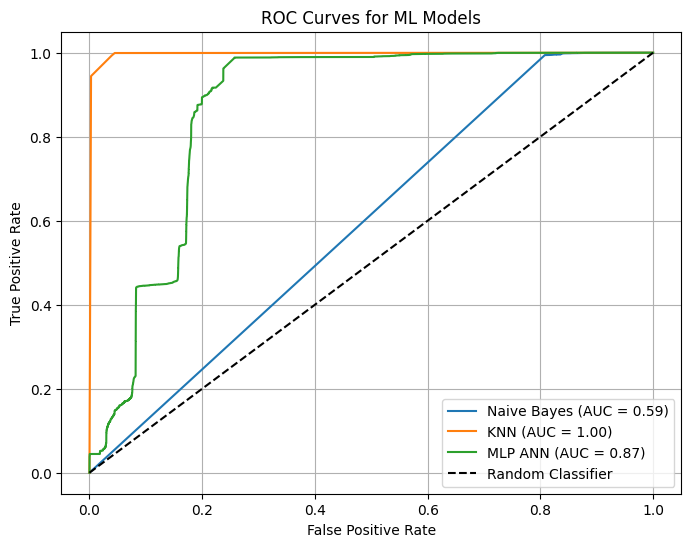

In [ ]:
  # Plot all ROC curves in one plot
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title("ROC Curves for ML Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()
